<p style="font-weight: bold;text-align: center;font-size: 2em;color: #00338D">Herschel PACS IFU Data Visualization and Analysis</p>

**Author:** Elena Puga
**Creation:** 05.08.2020

## Context
This notebook is a worked example on how to download, manipulate and perform a basic analysis on [__Herschel PACS__](https://www.cosmos.esa.int/web/herschel/legacy-documentation-pacs) data cubes, as the PACS instrument was the first Integral Field Unit on space.
The original analysis capabilities were a functionality provided by the Herschel Interactive Pipeline Environment (HIPE), which had the Spectrum explorer and contained dedicated toolboxes like: a) Spectrum Toolbox, b) SpectrumFitterGUI, and c) the Cube Toolbox.

New Python manipulation (`specutils`, `spectral-cube`) and visualization tools (`SpecViz`, `CubeViz`) have been developed in the context of future observatories ([__JWST__](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis#JWSTPost-PipelineDataAnalysis-JWSTJupyterNotebooks), Roman ST), and in this notebook we showcase the usability of these tools with existing calibrated and consolidated ESA data products. 

## Notebook Structure
- [Data access](#data_access)
- [Data manipulation and launching of visualization tool](#data_manipulation)
- [Data analysis](#data_analysis):
    1. Create 'sci' spectral cube, check dimensions  
    2. Create a Boolean Mask from the 'sci' finite data
    3. Extract the object 1D spectrum of the central spaxel and cast it in specutils.spectra.Spectrum1D
    4. 1D Model fitting:
       1. Examine with Spectrum Viewer User Interface, select spectral range and test the line+continuum model fit
       2. Automated cluster line + local continuum fit class
    5. Extraction of cube spectral slab
    6. Cube fitting (pixel-by-pixel) using the backend of the app model fitting plugin
    7. Continuum model evaluation and subtraction
    8. Make 2D emission line intensity maps collapsing the line emission cube (cubeviz)
    9. Create 2D line ratio maps

## Science case

Observation of the bipolar nebula IRAS 19312+1950 from the OT2_mcordine_2 program that exhibits both features of a massive oxigen-rich AGB star, and a young stellar object ([Cordiner et al. 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...828...51C)). 

**Note:** These are the only chopNod SED oversampled raster observations that PACS performed during its mission, displaying a plethora of spectral features, mostly CO, H$_2$O, OH and O lines 
***

<a id="data_access"></a>
## Data Access Workflow
The data access workflow is the following:
1. Herschel does not have an astroquery API and the `ESASky` module of `astroquery` has an ad-hoc function for _Herschel_ imaging observations. The accessible products are described [here](https://www.cosmos.esa.int/web/esdc/esasky-observations#HERSCHEL-OBS) 
2. Instead, we retrieve the cube using the `TapPlus` in [astroquery.utils.tap](https://astroquery.readthedocs.io/en/latest/utils/tap.html)

In [60]:
import tarfile
import os
import shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

In [96]:
from astropy.io import fits
from astropy import units as u
from astropy.nddata import StdDevUncertainty
import astropy.modeling.models as models
from astropy.table import Table
from astroquery.utils.tap.core import TapPlus
from astropy.wcs import WCS
from jdaviz.app import Application
from jdaviz.configs.default.plugins.model_fitting.fitting_backend import fit_model_to_spectrum
from jdaviz import SpecViz as spcv
from spectral_cube import SpectralCube, LazyMask
from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

from utils.pacs_linefittermult import LineFitterMult

## Download spectral data from Herschel Archive 

We search and download _Herschel_ _PACS_ cubes using as access the class `astroquery.utils.tap.core.TapPlus`

In [97]:
target_name = 'IRAS 19312+1950'

In [98]:
hsa = TapPlus(url="http://archives.esac.esa.int/hsa/whsa-tap-server/", tap_context='tap', data_context='data')

Created TAP+ (v20200428.1) - Connection:
	Host: archives.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


The definition of these parameters for _Herschel_ are analogue of those for the `curl`  [_Herschel_ Science Archive] (http://archives.esac.esa.int/hsa/archive-help/cl/product_access/product_access.html)

In [99]:
params_dict = {}
params_dict['OBSERVATION_ID'] = '1342245229'
params_dict['RETRIEVAL_TYPE'] = 'POSTCARD'
params_dict['INSTRUMENT_NAME'] = 'PACS'

hsa.load_data(params_dict=params_dict, output_file='hsa_pacs.jpg')   

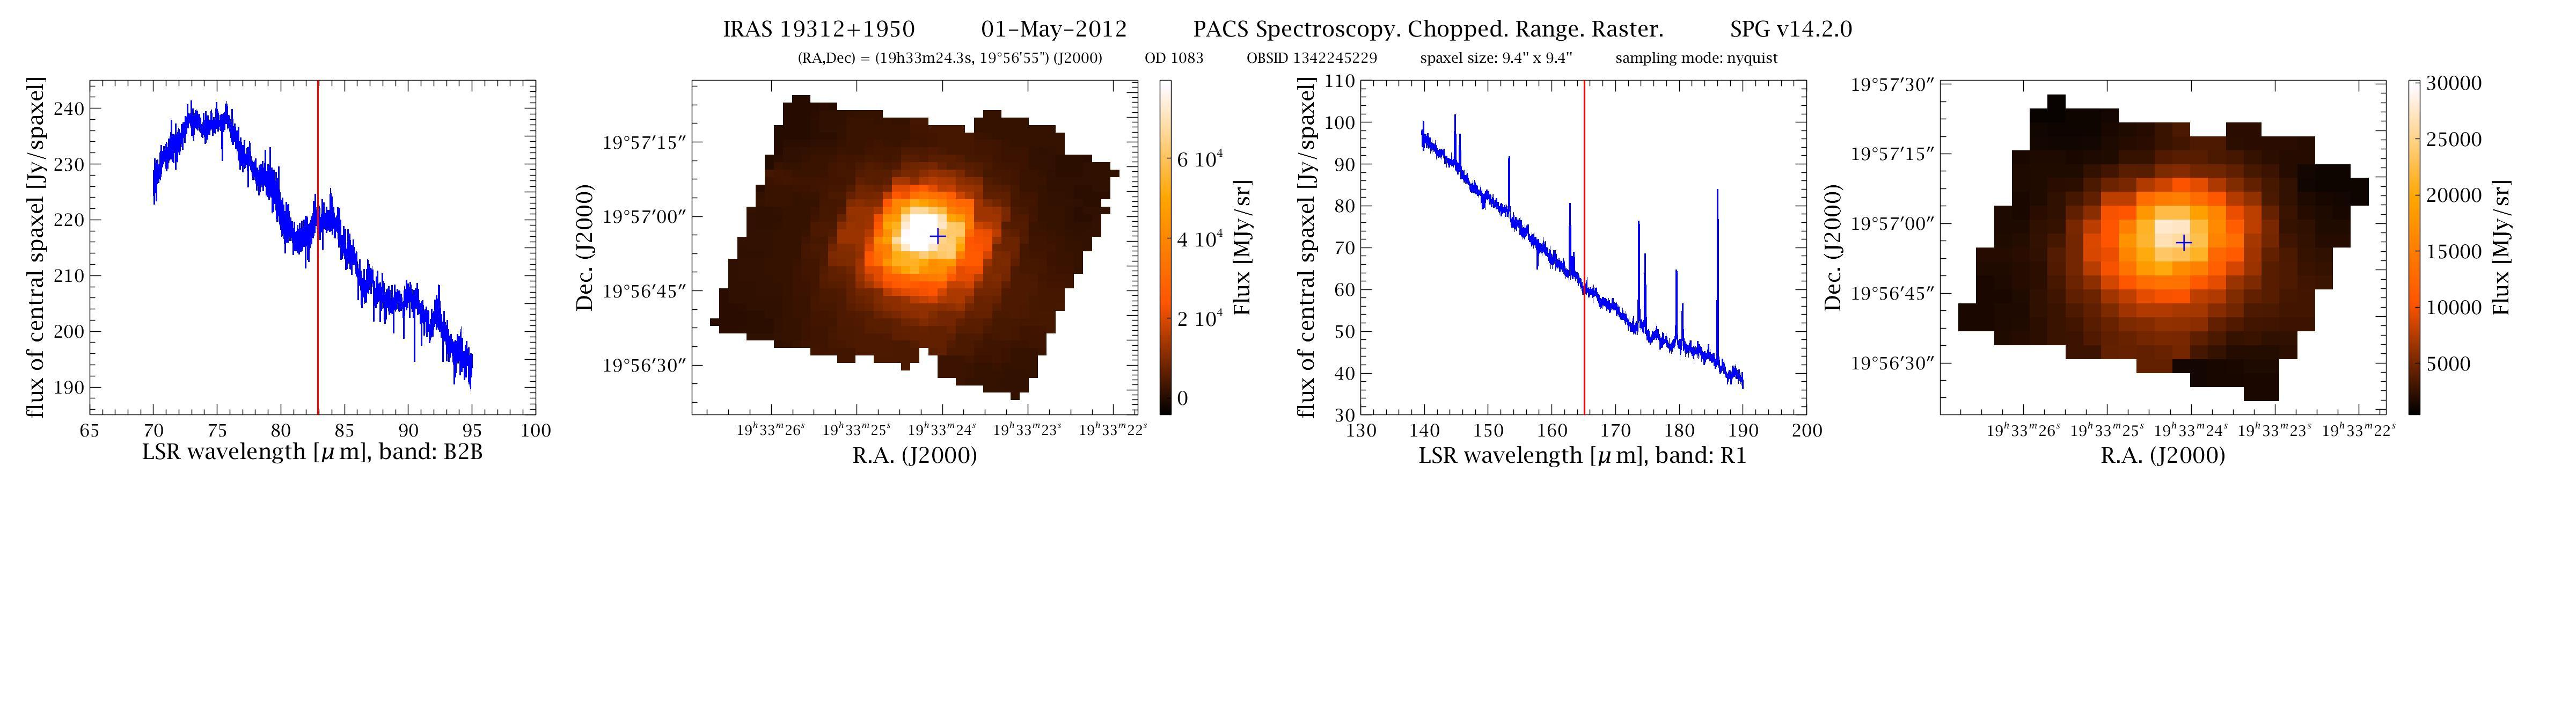

In [100]:
Image(filename='hsa_pacs.jpg')

In [ ]:
params_dict = {}
params_dict['OBSERVATION_ID'] = '1342245229'
params_dict['RETRIEVAL_TYPE'] = 'STANDALONE'
params_dict['INSTRUMENT_NAME'] = 'PACS'
params_dict['COMPRESS'] = True

hsa.load_data(params_dict=params_dict, output_file='pacs_sabp.tar.gz')   

For convenience, I already downloaded the PACS Standalone Browse products for the observation, with curl in a .tar.gz file. I chose those over Level2 data because Herschel Observation context is more complicated for PACS cubes. PACS Standalone Browse products are described ([here](http://herschel.esac.esa.int/hcss-doc-14.0/print/pacs-ppe/pacs-ppe.pdf)). 

In [102]:
hsa_data_path = '/Users/epuga/ESDC/pyesasky_demo/curl_test_pacs/'
tar = tarfile.open(os.path.join(hsa_data_path,'pacs_sabp.tar.gz'))
tar.extractall(path=hsa_data_path)
tar.close()


In [103]:
files = {}
# r=root, d=directories, f = files
for r, d, f in os.walk(hsa_data_path):
    for file in f:
        if '.fits' in file or '.fits.gz' in file:
            files[file] = os.path.join(r, file)


**Note: For Herschel standalone products each item in the list is a dictionary where the product name is the key and the HDUList is the value.**

In [104]:
sabps = {}
for key, value in files.items():
    hduList = fits.open(value)
    print('{}:'.format(hduList[0].header['TYPE']))
    hduList.info()
    sabps[hduList[0].header['TYPE']] = hduList

HPS3DEQPRS:
Filename: /Users/epuga/ESDC/pyesasky_demo/curl_test_pacs/anonymous1597333454/hpacs1342245229_20hps3deqprs_00_1469612623359.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     338   ()      
  1  image         1 ImageHDU        62   (25, 24, 4915)   float64   
  2  error         1 ImageHDU        62   (25, 24, 4915)   float64   
  3  coverage      1 ImageHDU        62   (25, 24, 4915)   float64   
  4  wcs-tab       1 BinTableHDU     37   1R x 2C   [4915D, 4915J]   
  5  flag          1 ImageHDU        38   (25, 24, 4915)   int16   
  6  History       1 ImageHDU        23   ()      
  7  HistoryScript    1 BinTableHDU     39   67R x 1C   [185A]   
  8  HistoryTasks    1 BinTableHDU     46   36R x 4C   [1K, 31A, 1K, 9A]   
  9  HistoryParameters    1 BinTableHDU     74   357R x 10C   [1K, 27A, 13A, 20A, 1L, 1K, 1L, 58A, 11A, 42A]   
HPS3DEQIBS:
Filename: /Users/epuga/ESDC/pyesasky_demo/curl_test_pacs/anonymous1597333454/hp

### WCS modification to comply with CubeViz cube standards

PACS has several Level 2 cubes for chopNod observations, depending on the spatial sampling in the raster maps: projected, drizzled, and interpolated. For this Nyquist sampled rastered map observation of a semi-extended source, we use the projected blue cube **HPS3DEQP[R|B]** 

In [105]:
pacs_product = 'HPS3DEQPRS'

In [106]:
#modification of CTYPE3, to be cubeViz compliant
extnames = {'image': 'sci', 'error': 'err', 'flag': 'dq'} #dq is not populated for PACS
for ext in ['image', 'error', 'flag']:
    sabps[pacs_product][ext].header['CTYPE3'] = 'WAVE'
    sabps[pacs_product][ext].header['EXTNAME'] = extnames[ext]

<a id="data_manipulation"></a>
## Data cube baseline preparation
Alternatively, one could create a loader

In [107]:
sabps[pacs_product].writeto(os.path.join(os.getcwd(), '{}_spectralCube.fits'.format(pacs_product)), overwrite=True)

In [108]:
hduList.close()

## Data cube optimal preparation

The spectral cube preparation consists on:
1. Remove PSF structure (cube spatial fitting?)
2. Match resolutions (PSF convolution with spectral-cube spectral_cube.spectral_cube.BaseSpectralCube.convolve_to)

***

## JDAVIZ tool - CubeViz embedded   

In [109]:
app = Application(configuration='cubeviz')
app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n â€¦

inferno


In [110]:
#test 2 - PACS parsed as hdu object
#pacs_path = os.path.join(os.getcwd(), '{}_spectralCube.fits'.format(pacs_product))
pacs_path = '/Users/epuga/ESDC/pyesasky_demo/myDemo/HPS3DEQPRS_spectralCube.fits'
app.load_data(pacs_path)

## Display settings:
* change Viewer wavelength to micron
* Change Layer Colormap of ImageViewer 1 and 2 to: Inferno

***

<a id="data_analysis"></a>
## Data Analysis Workflow
1. Create 'sci' spectral cube, check dimensions  
2. Create a Boolean Mask from the 'sci' finite data
3. Extract the object 1D spectrum of the central spaxel and cast it in specutils.spectra.Spectrum1D
4. 1D Model fitting:
   1. Examine with Spectrum Viewer User Interface, select spectral range and test the line+continuum model fit
   2. Automated cluster line + local continuum fit class
5. Extraction of cube spectral slab
6. Cube fitting (pixel-by-pixel) using the backend of the app model fitting plugin
7. Continuum model evaluation and subtraction
8. Make 2D emission line intensity maps collapsing the line emission cube (cubeviz)
9. Create 2D line ratio maps

Open the FITS file for reading

In [111]:
pacs_projected = fits.open(pacs_path)

In [113]:
#1. Create sci spectral cube with units, check dimensions
funit = u.Jy
wunit = u.um
flux = pacs_projected['sci'].data * funit
err = pacs_projected['err'].data * funit

wcs = WCS(pacs_projected['sci'])
sc = SpectralCube(data=flux, wcs=wcs)
mask = LazyMask(np.isfinite, cube=sc)
sc2 = sc.with_mask(mask)
sc_um = sc2.with_spectral_unit(wunit)

print(sc_um)
print('Note: {}'.format('cube shape convention: (n_s, n_y, n_x)'))
print('The cube has flux units of {}'.format(sc_um.unit))
print('The cube has spectral_axis units of {}'.format(sc_um.spectral_axis.unit))

SpectralCube with shape=(4915, 24, 25) and unit=Jy:
 n_x:     25  type_x: RA---TAN  unit_x: deg    range:   293.340740 deg:  293.362018 deg
 n_y:     24  type_y: DEC--TAN  unit_y: deg    range:    19.938972 deg:   19.958140 deg
 n_s:   4915  type_s: WAVE      unit_s: um     range:      139.550 um:     190.028 um
Note: cube shape convention: (n_s, n_y, n_x)
The cube has flux units of Jy
The cube has spectral_axis units of um


In [114]:
#3. Extract and cast object spectrum1D of central spaxel
_, ny, nx = sc_um.shape
flux_cnt = sc_um[:, ny//2, nx//2] 
err_cnt = err[:, ny//2, nx//2] 
wave = sc_um.spectral_axis
wave.unit, flux_cnt.unit

(Unit("um"), Unit("Jy"))

In [115]:

spectrum_cnt = Spectrum1D(spectral_axis=wave, flux=flux_cnt, uncertainty=StdDevUncertainty(err_cnt))
#Spectrum viewer loading
app.add_data(spectrum_cnt, data_label='Central pixel ({},{}) spectrum'.format(nx, ny))
app.add_data_to_viewer('spectrum-viewer', 'Central pixel ({},{}) spectrum'.format(nx, ny), clear_other_data=True)

#Because this is Glue, you can programatically configure viewers
#Modify settings for the (only) layer shown
v = app.get_viewer('spectrum-viewer')
v.state.layers[0].color = 'blue'
v.state.layers[0].linewidth = 2

#Retrieving data product to save as .fits file
spec_data = app.get_data_from_viewer('spectrum-viewer')
#spec_data
spec = spec_data['Central pixel ({},{}) spectrum'.format(nx, ny)]
spec.write('{}_cntr_spaxel.fits'.format(os.path.splitext(os.path.basename(pacs_path))[0]), format='tabular-fits', overwrite=True)

In [116]:
# Modify viewer-level options: zoom
v.state.x_min = 145.
v.state.x_max = 155.
v.state.y_min = 6.
v.state.y_max = 10.

In [117]:
#4.A Examine with Spectrum Viewer and test the continuum fitting parameters
wlines = {'CO14-13': [185.999], 'CO15-14': [173.631]}

#Select spectral region in the UI creating a Subset 1
subset = app.get_subsets_from_viewer('spectrum-viewer')['Subset 1']
unit = subset.meta.get('spectral_axis_unit', u.Unit('micron'))
spec_reg_ui = SpectralRegion.from_center(subset.center.x * unit, subset.width * unit)
spec_reg_ui

#A spectral region extraction may be done programatically with a combination of 
#specutils.spectra.SpectralRegion and specutils.manipulation.extract_region

Spectral Region, 1 sub-regions:
  (152.65224561242127 um, 153.7913474744147 um) 

Load the UI application model fitting plugin in the Spectrum Viewer and generate a compound Model of a line+continuum region.<br>
PACS continuum has an in-band uncertainty of XX, and that is the reason why it is recommended a local fit of lines+continuum.<br>
If you want to fit only the continuum, you may either:
- mask the line and fit only the continuum
- include the line and increase the relative contribution of the continuum fitting spectral range. This is not always possible with numerous lines 

Since efficiently masking lines involves as much work as fitting them, a simple approach is to fit simultaneously line(s) and continuum. <br> 
The class `LineFitterMult` uses the PACS spectral resolution calibration file to estimate the width of the spectral region to fit and uses a multiple line model using 1D Gaussians and a Polynomial of order 1 to represent the local continuum.


Centre: [186.02895352], Peak: [3.709409], FWHM: [0.11296768]


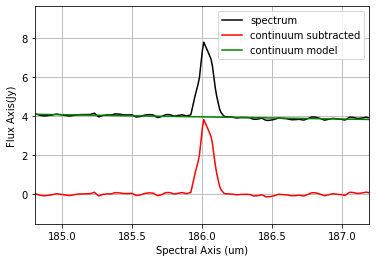

In [118]:
#4.B Use the local class 'LineFitterMult'
wline = wlines['CO14-13']
band = 'R1'

line = LineFitterMult(spectrum_cnt, wline, band, polyOrder=1, widthFactor=10, verbose=0)

print('Centre: {}, Peak: {}, FWHM: {}'.format(line.get_line_centre(), line.get_line_peak(), line.get_line_fwhm()))
plt.plot(spectrum_cnt.spectral_axis, spectrum_cnt.flux, label='spectrum', color='k')
plt.plot(spectrum_cnt.spectral_axis, line.get_line_spec().flux, label='continuum subtracted', color='r')  # with units
plt.plot(spectrum_cnt.spectral_axis, line.continuumModel(spectrum_cnt.spectral_axis.value), label='continuum model', color='g')
plt.xlim((line.get_wmin(), line.get_wmax()))
plt.xlabel('Spectral Axis ({})'.format(spectrum_cnt.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(spectrum_cnt.flux.unit)) 
plt.grid(True) 
plt.legend()

In [119]:
#5. Cube extraction for cube fitting efficiency
# Extracting a cube spectral slab between two spectral coordinates
sc_slab = sc_um.spectral_slab(line.get_wmin() * u.um, line.get_wmax() * u.um)  
print(sc_slab)

SpectralCube with shape=(234, 24, 25) and unit=Jy:
 n_x:     25  type_x: RA---TAN  unit_x: deg    range:   293.340740 deg:  293.362018 deg
 n_y:     24  type_y: DEC--TAN  unit_y: deg    range:    19.938972 deg:   19.958140 deg
 n_s:    234  type_s: WAVE      unit_s: um     range:      184.800 um:     187.193 um


#6. Pixel by pixel cube fitting using the initialized model (only valid for the spectral region)
<!-- # component_list : list
#     Spectral model subcomponents stored in a list.
#     Their `name` attribute must be unique. Each subcomponent
#     should be an initialized object from `astropy.modeling.models'
# expression : str
#     The arithmetic expression that combines together
#     the model subcomponents. The subcomponents are
#     refered via their 'name' attribute.
 -->

In [121]:
# This cell takes the compoundModel fitted to the central spaxel spectrum
model_init = line.get_line_model()            
print(model_init)

<QuantityModel CompoundModel(c0_0=24.56368156, c1_0=-0.11077251, amplitude_1=3.709409, mean_1=186.02895352, stddev_1=0.04797296), input_units=um, return_units=Jy>


In [45]:
#model_init.param_names
len(model_init.parameters)
component_list = model_init._leaflist
expression = model_init._format_expression()
names = model_init.submodel_names
n_submodels = model_init.n_submodels
for i in range(n_submodels):
    expression = expression.replace('[{}]'.format(i), names[i])
expression
from asteval import Interpreter
model_dict = {}
for component in component_list:
        model_dict[component.name] = component
aeval = Interpreter(usersyms=model_dict)
model = aeval(expression)
#len(model.parameters)
model_dict['a'] = model_dict['0']
model_dict['b'] = model_dict['1']
expression = 'a + b'
aeval = Interpreter(usersyms=model_dict)
model = aeval(expression)
len(model.parameters)
component_list[0].name='a'
component_list[1].name='b'


[<Polynomial1D(1, c0=24.56368156, c1=-0.11077251, name='a')>,
 <Gaussian1D(amplitude=3.709409, mean=186.02895352, stddev=0.04797296, name='b')>]

In [122]:
# decomposing the compoundModel prescription into: 1) model components in a list 
# and 2) the model arithmetic expression    
component_list = model_init._leaflist
expression = model_init._format_expression()

names = model_init.submodel_names
n_submodels = model_init.n_submodels
for i in range(n_submodels):
    expression = expression.replace('[{}]'.format(i), names[i])
expression
#component_list

'cont + g1'

In [123]:
# casting cube into a Spectrum1D to use the backend fitting generalized for a cube 
nan_mask = ~sc_slab.get_mask_array()
cube_spec = Spectrum1D(spectral_axis=sc_slab.spectral_axis, flux=np.transpose(sc_slab.filled_data[:], (1,2,0)), 
                       mask=np.transpose(nan_mask, (1,2,0)))
fitted_pars, fitted_spectrum = fit_model_to_spectrum(cube_spec, component_list,
                                                     expression, run_fitter=True);

<!-- Returns
-------
:list: a list that stores 2D arrays. Each array contains one
    parameter from `astropy.modeling.CompoundModel` instances
    fitted to every spaxel in the input cube.
:class:`specutils.spectrum.Spectrum1D`
    The spectrum that stores the fitted model values in its 'flux'
    attribute.
-->    
cube_from_model taking advantage that the model parameters can be of any size, provided they are broadcastable (like numpy arrays)
It would be good to display the fitted model values in one of the cube uncert-viewer

In [124]:
#7. Continuum model evaluation and subtraction
continuum_model = model_init.unitless_model[0]
p_names = continuum_model.param_names
for name in p_names:
    if isinstance(fitted_pars[i+1], np.ndarray):
        continuum_model[name].value = fitted_pars[i+1] 
continuum_cube = continuum_model(cube_spec.spectral_axis) #the outcome is a 3D Spectrum1d?

# TODO: cube arithmetic subtract continuum to slab cube
#fitted_model is no longer a `:class:`astropy.modeling.models.CompoundModel`, it is a 3D :class:`specutils.spectrum.Spectrum1D`. It would be great to have a cube_from_model analogue to `specutils.manipulation.spectrum_from_model`

KeyError: 2

In [ ]:
8